### Import packages

In [2]:
import pandas as pd
import numpy as np
import os
import copy
import matplotlib.pyplot as plt
from colour import Color
import altair as alt
alt.renderers.enable('notebook')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import clear_output

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', None)

### Import data

In [3]:
# FETCH
url = 'https://raw.githubusercontent.com/wyoungky/Happiness-Index/master/data/world-happiness/'
file_name = ['2015.csv', '2016.csv', '2017.csv', '2018.csv', '2019.csv']

number = 0 
for file in file_name:
    info_temp = pd.read_csv(url + file)
    
    ## get date of the record.
    info_temp['Year'] = file.split(".")[0]
    
    if number == 0:
        happiness_data = copy.deepcopy(info_temp)
        number += 1
    else:
        happiness_data = pd.concat([happiness_data,info_temp], sort=True)

In [4]:
## import main data from folder
file_directory = "./data/world-happiness/"
all_files = os.listdir(file_directory)

number = 0 
for file in all_files:
    info_temp = pd.read_csv(file_directory + file)
    
    ## get date of the record.
    info_temp['Year'] = file.split(".")[0]
    
    if number == 0:
        happiness_data = copy.deepcopy(info_temp)
        number += 1
    else:
        happiness_data = pd.concat([happiness_data,info_temp], sort=True)


### Exploratory Analysis

In [5]:
# pivot to get yearly value
happiness_data_yearly = (happiness_data.pivot_table(index=['Country','Region'], 
                                                    columns='Year',
                                                    values='Happiness Score')
                         .rename_axis(None, axis=1)
                         .reset_index())

# fill from previous years, if cannot, fill from following years

column_to_rank = [2015, 2016, 2017, 2018, 2019]
# calculate rank
for year in column_to_rank:
    # calculate rank
    new_col_name_rank = "rank_" + str(year)
    rank = happiness_data_yearly[str(year)].rank(ascending=False)
    happiness_data_yearly[new_col_name_rank] = rank
    
# calculate average rank
rank_col = [col for col in happiness_data_yearly if col.startswith('rank')]
happiness_data_yearly["avg_rank"] = happiness_data_yearly[rank_col].mean(axis=1).round(1)
    
# calculate score change
# calculate rate of change
# calculate rank change
for year in column_to_rank[:-1]:
    year_later_list = [i for i in column_to_rank if i > year]
    for year_later in year_later_list:
        # calculate rank change
        new_col_name_s = "rank_" + str(year) + "_" + str(year_later)
        score_change = ((happiness_data_yearly["rank_" + str(year)]
                         -happiness_data_yearly["rank_"  + str(year_later)]))
        happiness_data_yearly[new_col_name_s] = score_change

        # calculate score change
        new_col_name_s = "score_" + str(year) + "_" + str(year_later)
        score_change = ((happiness_data_yearly[str(year_later)]
                         -happiness_data_yearly[str(year)])).round(3)
        happiness_data_yearly[new_col_name_s] = score_change

happiness_data_yearly.rename(columns={'2015':"score_2015", 
                                      '2016':"score_2016", 
                                      '2017':"score_2017", 
                                      '2018':"score_2018", 
                                      '2019':"score_2019"},
                             inplace=True)   

### Plot Charts

In [6]:
def altair_chart(df, col_x, col_y):
    altair_data = copy.deepcopy(df)
    altair_data['guideline'] = np.arange(len(altair_data))/(len(altair_data)-1)*6+2

    chart = alt.Chart(altair_data)

    selection1 = alt.selection_multi(fields=['Region'], bind='legend')
    selection2 = alt.selection_single(empty='all', fields=['Country'])

    xscale = alt.Scale(domain=(2.0, 8.0))
    yscale = alt.Scale(domain=(2.0, 8.0))

    scatter = chart.mark_point().encode(
        alt.X(col_x, scale = xscale),
        alt.Y(col_y, scale = yscale),

        color=alt.condition(selection2,'Region:N',alt.value('lightgray'),scale=alt.Scale(scheme='tableau20')),
        tooltip=['Country', col_x, col_y],
        opacity=alt.condition(selection1, alt.value(1), alt.value(0.2))
    ).add_selection(
        selection1,
        selection2
    ).properties(
        height=500,
        width=500
    )


    xmean = chart.mark_rule().encode(
        x='mean(' + col_x + '):Q',
        size=alt.value(0.1),
        color=alt.value('blue')
    ).transform_filter(
        selection1 | selection2
    )

    text_xmean = chart.mark_text(
        text='mean', angle=270, align='left', baseline='bottom', opacity=0.5, color="blue"
    ).encode(
        x='mean(' + col_x + '):Q', y=alt.value(490)
    ).transform_filter(
        selection1 | selection2
    )

    ymean = chart.mark_rule().encode(
        y='mean(' + col_y + '):Q',
        size=alt.value(0.1),
        color=alt.value('blue')
    ).transform_filter(
        selection1 | selection2
    )

    text_ymean = chart.mark_text(
        text='mean', angle=0, align='left', baseline='bottom', opacity=0.5, color="blue"
    ).encode(
        x=alt.value(10), y='mean(' + col_y + '):Q'
    ).transform_filter(
        selection1 | selection2
    )

    guideline = chart.mark_line(strokeDash=[10,5]).encode(
        alt.X('guideline', scale = xscale),
        alt.Y('guideline', scale = yscale),
        size=alt.value(0.5)
    )


    chart2 = chart.mark_bar().encode(
        x='count()',
        y=alt.Y(col_y, bin=alt.Bin(maxbins=30, extent=yscale.domain)),
        color='Region:N'
    ).transform_filter(
        selection1 | selection2
    ).properties(
        height=500,
        width=100
    )

    chart3 = chart.mark_bar().encode(
        y='count(Country)',
        x=alt.X(col_x, bin=alt.Bin(maxbins=30, extent=xscale.domain)),
        color='Region:N'
    ).transform_filter(
        selection1 | selection2
    ).properties(
        height=100,
        width=500
    )

    return (((scatter+xmean+text_xmean+ymean+text_ymean+guideline) | chart2 ) & chart3)

Dropdown(description='x-axis Year:', index=2, options=((2015, 'score_2015'), (2016, 'score_2016'), (2017, 'sco…

Dropdown(description='y-axis Year:', index=4, options=((2015, 'score_2015'), (2016, 'score_2016'), (2017, 'sco…

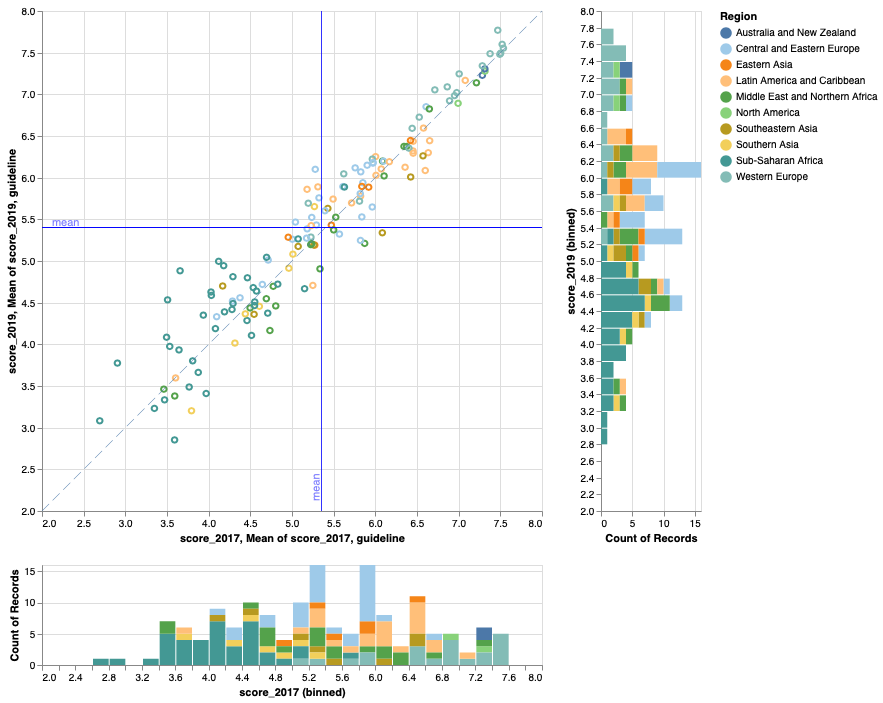

In [7]:
year=[(2015,'score_2015'),
      (2016,'score_2016'),
      (2017,'score_2017'),
      (2018,'score_2018'),
      (2019,'score_2019')]

w1 = widgets.Dropdown(options=year,
                 value='score_2015',
                 description='x-axis Year:')
w2 = widgets.Dropdown(options=year,
                 value='score_2019',
                 description='y-axis Year:')
display(w1)
display(w2)
display(altair_chart(happiness_data_yearly, w1.value, w2.value))

def on_change(change):
    global chart
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(w1)
        display(w2)
        display(altair_chart(happiness_data_yearly, w1.value, w2.value))

w1.observe(on_change)
w2.observe(on_change)

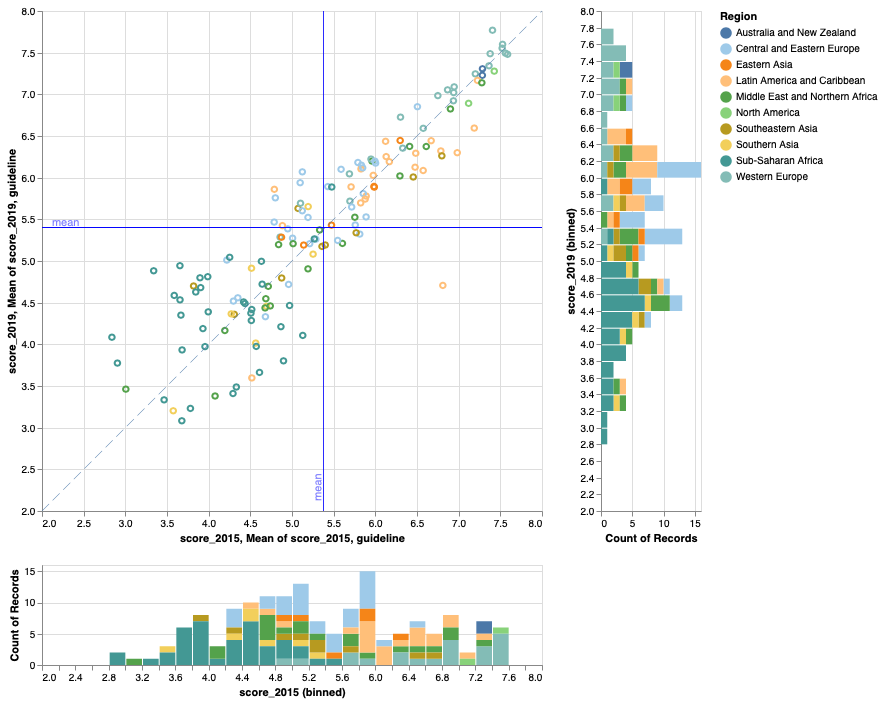

In [8]:
altair_chart(happiness_data_yearly, w1.value, w2.value)

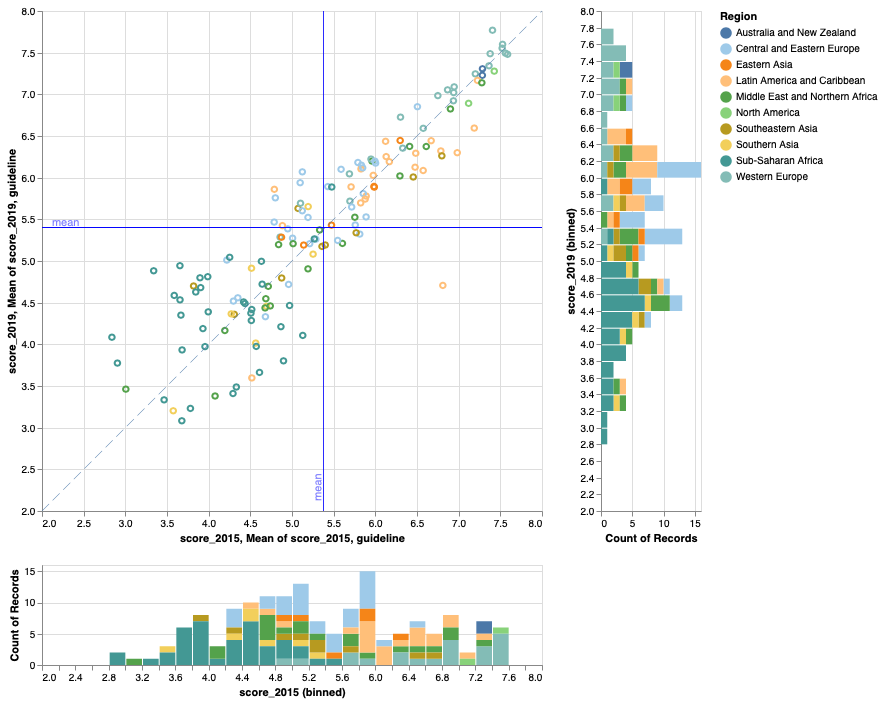

In [12]:

altair_data = copy.deepcopy(happiness_data_yearly)
altair_data['guideline'] = np.arange(len(altair_data))/(len(altair_data)-1)*6+2

chart = alt.Chart(altair_data)

selection1 = alt.selection_multi(fields=['Region'], bind='legend')
selection2 = alt.selection_single(empty='all', fields=['Country'])

xscale = alt.Scale(domain=(2.0, 8.0))
yscale = alt.Scale(domain=(2.0, 8.0))

scatter = chart.mark_point().encode(
    alt.X('score_2015', scale = xscale),
    alt.Y('score_2019', scale = yscale),

    color=alt.condition(selection2,'Region:N',alt.value('lightgray'),scale=alt.Scale(scheme='tableau20')),
    tooltip=['Country', 'score_2015', 'score_2019'],
    opacity=alt.condition(selection1, alt.value(1), alt.value(0.2))
).add_selection(
    selection1,
    selection2
).properties(
    height=500,
    width=500
)


xmean = chart.mark_rule().encode(
    x='mean(' + 'score_2015' + '):Q',
    size=alt.value(0.1),
    color=alt.value('blue')
).transform_filter(
    selection1 | selection2
)

text_xmean = chart.mark_text(
    text='mean', angle=270, align='left', baseline='bottom', opacity=0.5, color="blue"
).encode(
    x='mean(' + 'score_2015' + '):Q', y=alt.value(490)
).transform_filter(
    selection1 | selection2
)

ymean = chart.mark_rule().encode(
    y='mean(' + 'score_2019' + '):Q',
    size=alt.value(0.1),
    color=alt.value('blue')
).transform_filter(
    selection1 | selection2
)

text_ymean = chart.mark_text(
    text='mean', angle=0, align='left', baseline='bottom', opacity=0.5, color="blue"
).encode(
    x=alt.value(10), y='mean(' + 'score_2019' + '):Q'
).transform_filter(
    selection1 | selection2
)

guideline = chart.mark_line(strokeDash=[10,5]).encode(
    alt.X('guideline', scale = xscale),
    alt.Y('guideline', scale = yscale),
    size=alt.value(0.5)
)


chart2 = chart.mark_bar().encode(
    x='count()',
    y=alt.Y('score_2019', bin=alt.Bin(maxbins=30, extent=yscale.domain)),
    color='Region:N'
).transform_filter(
    selection1 | selection2
).properties(
    height=500,
    width=100
)

chart3 = chart.mark_bar().encode(
    y='count(Country)',
    x=alt.X('score_2015', bin=alt.Bin(maxbins=30, extent=xscale.domain)),
    color='Region:N'
).transform_filter(
    selection1 | selection2
).properties(
    height=100,
    width=500
)

((scatter+xmean+text_xmean+ymean+text_ymean+guideline) | chart2 ) & chart3

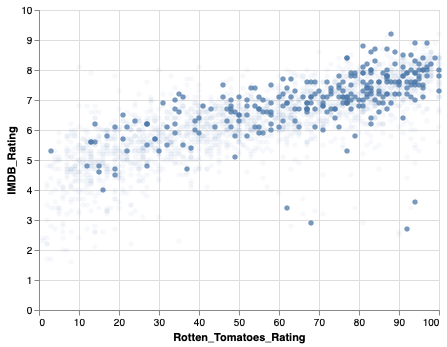

In [15]:
movies = 'https://vega.github.io/vega-datasets/data/movies.json'

df = pd.read_json(movies) # load movies data
genres = df['Major_Genre'].unique() # get unique field values
genres = list(filter(lambda d: d is not None, genres)) # filter out None values
genres.sort() # sort alphabetically

mpaa = ['G', 'PG', 'PG-13', 'R', 'NC-17', 'Not Rated']

# single-value selection over [Major_Genre, MPAA_Rating] pairs
# use specific hard-wired values as the initial selected values
selection = alt.selection_single(
    name='Select',
    fields=['Major_Genre', 'MPAA_Rating'],
    init={'Major_Genre': 'Drama', 'MPAA_Rating': 'R'},
    bind={'Major_Genre': alt.binding_select(options=genres), 'MPAA_Rating': alt.binding_radio(options=mpaa)}
)
  
# scatter plot, modify opacity based on selection
alt.Chart(movies).mark_circle().add_selection(
    selection
).encode(
    x='Rotten_Tomatoes_Rating:Q',
    y='IMDB_Rating:Q',
    tooltip='Title:N',
    opacity=alt.condition(selection, alt.value(0.75), alt.value(0.05))
)

### Sources and Reference

Dataset: https://www.kaggle.com/unsdsn/world-happiness/data